In [2]:
import alborex_functions
import alborexdata
import netCDF4
import glob
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import cmocean
import numpy as np
import datetime
from importlib import reload

In [18]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

In [4]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Configuration

In [5]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

Create a logger

In [6]:
logger = alborexdata.configure_logging("./logs/alborexFigure4.log")

Domain

In [7]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]

Create a list of netCDF files containing SST

In [8]:
figdir = config["figdir"]
sstdir = config["datadirs"]["sst"]
coastfile = config["datafiles"]["coast"]

# Data reading and plotting

Make figure directory if necessary.

In [9]:
if os.path.isdir(figdir):
    logger.debug("Figure directory {0} already exists".format(figdir))
else:
    os.makedirs(figdir)
    logger.debug("Creating figure directory {0}".format(figdir))

2018-08-28 11:12:12,937 - alborex_logger - DEBUG - Figure directory /home/ctroupin/Publis/201703_AlborexData/figures already exists


## Load data
### Coastline

In [10]:
loncoast, latcoast = alborexdata.read_lonlat_coast(coastfile)

### Front position

In [11]:
frontcoords = "../data/front_coordinates.dat"
f = alborexdata.Front()
f.get_from_file(frontcoords)
f.smooth()

### Gliders

In [12]:
glider1 = alborexdata.Glider()
glider1.get_from_netcdf(config["datafiles"]["gliders"][0])

In [13]:
glider2 = alborexdata.Glider()
glider2.get_from_netcdf(config["datafiles"]["gliders"][1])

### Apply some quality control

In [14]:
glider1.temperature = np.ma.masked_outside(glider1.temperature, 13., 20., copy=True)
glider2.temperature = np.ma.masked_outside(glider2.temperature, 13., 20., copy=True)

## Plot options
### Colorbar limits

In [15]:
Tmin, Tmax = 13., 20.
boundsT = np.arange(Tmin, Tmax, 1.)
normT = colors.Normalize(vmin=Tmin, vmax=Tmax)

Smin, Smax = 36.5, 38.5
boundsS = np.arange(Smin, Smax, 0.25)
normS = colors.Normalize(vmin=Smin, vmax=Smax)

chloroCTDmin,chloroCTDmax = 0.01,1.5
normchloro = colors.LogNorm(vmin=chloroCTDmin,vmax=chloroCTDmax)
cmapCTDchloro = plt.cm.YlGnBu_r

### Depths and angles

In [16]:
depths = np.array((-600, 0, 100))
angles = np.array((40, -20))

## Make the plot

In [17]:
# Coordinates of the front in the region of interest
goodcoords = np.where( (f.lon >= coordinates2[0]) & (f.lon <= coordinates2[1]))[0]

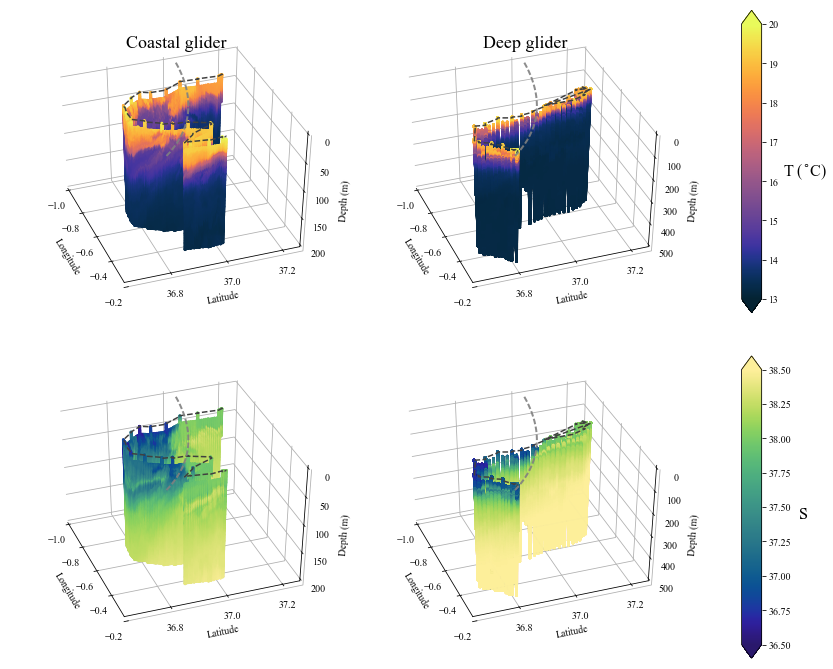

In [75]:
figname = "fig07"
fig, ax1, ax2, ax3, ax4, cbar_ax1, cbar_ax2 = alborexdata.prepare_3D_scat4()

# Change wall properties
alborexdata.change_wall_prop(ax1, coordinates2, np.array((-200, 0., 50)), angles)
alborexdata.change_wall_prop(ax2, coordinates2, np.array((-500, 0., 100)), angles)
alborexdata.change_wall_prop(ax3, coordinates2, np.array((-200, 0., 50)), angles)
alborexdata.change_wall_prop(ax4, coordinates2, np.array((-500, 0., 100)), angles)

NN = 1
# Plot the glider profiles
scat3Dg1 = ax1.scatter(glider1.lon[::NN], glider1.lat[::NN], -glider1.depth[::NN],
                      s=3, c=glider1.temperature[::NN], edgecolor=None,
                      cmap=cmocean.cm.thermal, zorder=4, vmin=Tmin, vmax=Tmax)

scat3Dg2 = ax2.scatter(glider2.lon[::NN], glider2.lat[::NN], -glider2.depth[::NN],
                      s=3, c=glider2.temperature[::NN], edgecolor=None,
                      cmap=cmocean.cm.thermal, zorder=4, vmin=Tmin, vmax=Tmax)

scat3Dg3 = ax3.scatter(glider1.lon[::NN], glider1.lat[::NN], -glider1.depth[::NN],
                      s=3, c=glider1.salinity[::NN], edgecolor=None,
                      cmap=cmocean.cm.haline, zorder=4, vmin=Smin, vmax=Smax)

scat3Dg3 = ax4.scatter(glider2.lon[::NN], glider2.lat[::NN], -glider2.depth[::NN],
                      s=3, c=glider2.salinity[::NN], edgecolor=None,
                      cmap=cmocean.cm.haline, zorder=4, vmin=Smin, vmax=Smax)

# Plot the glider tracks
ax1.plot3D(glider1.lon, glider1.lat, 0. , '--', color="0.25")
ax2.plot3D(glider2.lon, glider2.lat, 0. , '--', color="0.25")
ax3.plot3D(glider1.lon, glider1.lat ,0 , '--', color="0.25")
ax4.plot3D(glider2.lon, glider2.lat ,0 , '--', color="0.25")

# Plot the front :)
ax1.plot3D(f.lon[goodcoords], f.lat[goodcoords], 0.0, "--", 
           color=".5", linewidth=2, alpha=.9)
ax2.plot3D(f.lon[goodcoords], f.lat[goodcoords], 0.0, "--", 
           color=".5", linewidth=2, alpha=.9)
ax3.plot3D(f.lon[goodcoords], f.lat[goodcoords], 0.0, "--", 
           color=".5", linewidth=2, alpha=.9)
ax4.plot3D(f.lon[goodcoords], f.lat[goodcoords], 0.0, "--", 
           color=".5", linewidth=2, alpha=.9)

## Add the colorbars
# Temperature
cbar1 = fig.colorbar(scat3Dg1, cax=cbar_ax1, orientation='vertical', 
                    norm=normT, extend='both')

cbar1.set_label('T ($^{\circ}$C)', rotation=0, ha="left", fontsize=16)
cbar1.set_clim(Tmin, Tmax)
#cbar1.set_ticks(boundsT)
#cbar1.ax.set_xticklabels(boundsT, fontsize=16)

### Salinity
cbar2 = fig.colorbar(scat3Dg3, cax=cbar_ax2, orientation='vertical', 
                    norm=normS, extend='both')

cbar2.set_label(' S', rotation=0, ha="left", fontsize=16)
cbar2.set_clim(Smin, Smax)
#cbar2.set_ticks(boundsS)
#cbar2.ax.set_xticklabels(boundsS, fontsize=16)

fig.subplots_adjust(wspace=0.05, hspace=.05)
plt.savefig(os.path.join(figdir, figname), dpi=300, facecolor='w', 
            edgecolor='w',transparent=False, 
            bbox_inches='tight', pad_inches=0.)
plt.show()
plt.close()

## Some diagnostics (mean resolution, number of profiles etc)

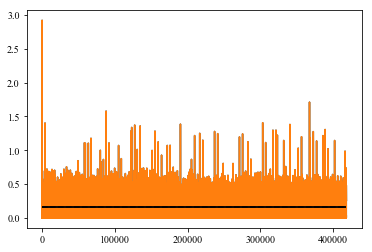

In [34]:
plt.plot(abs(glider1.depth[1:] - glider1.depth[:-1]), zorder=2)
plt.hlines(np.mean(abs(glider1.depth[1:] - glider1.depth[:-1])), 0, len(glider1.depth),
           color='k', zorder=3)
plt.hlines(np.median(abs(glider1.depth[1:] - glider1.depth[:-1])), 0, len(glider1.depth),
           color='k', linestyle="--", zorder=3)
plt.show()
plt.close()

In [36]:
np.mean(abs(glider1.depth[1:] - glider1.depth[:-1]))

0.16849587419667525

In [41]:
np.mean(abs(glider2.depth[1:] - glider2.depth[:-1]))

0.16018559029585439

In [37]:
np.median(abs(glider1.depth[1:] - glider1.depth[:-1]))

0.16424501147875503

In [38]:
len(glider1.temperature.compressed())

121513

In [39]:
len(glider2.temperature.compressed())

226717